##### Copyright © 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 統合勾配

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/interpretability/integrated_gradients">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/interpretability/integrated_gradients.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colabで実行</a>
</td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/interpretability/integrated_gradients.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">	GitHub でソースを表示</a> </td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/interpretability/integrated_gradients.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
  <td><a href="https://tfhub.dev/google/imagenet/inception_v1/classification/4"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF Hub モデルを見る</a></td>
</table>

このチュートリアルでは、[説明可能な AI](https://en.wikipedia.org/wiki/Explainable_artificial_intelligence) テクニック「[Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365)」という論文で紹介された[説明可能な AI](https://en.wikipedia.org/wiki/Explainable_artificial_intelligence) テクニックである**統合勾配（IG、Integrated Gradients）**の実装方法を実演します。IG は特徴量の観点からモデルの予測間の関係について説明することを目的としています。特徴量重要度の理解、データの歪みの識別、およびモデル性能のデバッグなど、多様なユースケースがあります。

IG は、大規模なネットワークや画像などの特徴空間への拡張を可能にする代替アプローチと比較した場合に、あらゆる微分可能モデル（画像、テキスト、構造化データなど）への用途性の高さ、実装しやすさ、理論的正当性、および計算効率性により、利用者の多い解釈可能性テクニックとなりました。

このチュートリアルでは、IG の実装を手順を追って説明し、画像分類器のピクセル特徴量重要度を理解します。例として、消防艇が放水しているこちらの[画像](https://commons.wikimedia.org/wiki/File:San_Francisco_fireboat_showing_off.jpg)を使用します。この画像を消防艇として分類し、消防艇と放水器を構成するピクセルを、決定に重要な要素としてハイライトします。モデルは、このチュートリアルの後の方でもこの画像を消防艇として分類しますが、決定を説明する際に、同じピクセルを重要としてハイライトするでしょうか？

「IG 属性マスク」と「元の画像 + IG マスクのオーバーレイ」という以下の画像では、モデルが消防艇の放水器と放水を構成するピクセルを（紫色で）ハイライト表示し、消防艇自体よりも決定に重要であることを確認できます。モデルはどのように新しい消防艇を一般化するでしょうか。放水がない消防艇はどのように分類されるでしょうか。IG がどのように機能するのか、また IG をどのようにモデルに適用すれば、予測と基盤の特徴量の関係をさらに理解できるようになるのかについて、以下で説明しています。

![出力画像 1](images/IG_fireboat.png)

## 設定

In [2]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

2024-01-11 18:04:12.368225: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 18:04:12.368274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 18:04:12.369765: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### トレーニング済みの画像分類器を TF-Hub からダウンロードする

IG は、あらゆる微分可能なモデルに適用できます。元の論文の趣旨にしたがい、同じモデルのトレーニング済みバージョンである Inception V1 を使用します。これは [TensorFlow Hub](https://tfhub.dev/google/imagenet/inception_v1/classification/4) からダウンロードします。

In [3]:
model = tf.keras.Sequential([
    hub.KerasLayer(
        name='inception_v1',
        handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4',
        trainable=False),
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 inception_v1 (KerasLayer)   (None, 1001)              6633209   


Total params: 6633209 (25.30 MB)


Trainable params: 0 (0.00 Byte)


Non-trainable params: 6633209 (25.30 MB)


_________________________________________________________________


モジュールページより、Inception V1 について、次の内容に注意しておく必要があります。

**入力**: 期待されるモデルの入力形状は `(None, 224, 244, 3,)` です。これは、dtype float32 と形状 `(batch_size, height, width, RGB channels)` の密な 4D テンソルで、要素は 範囲 [0, 1] に正規化されたピクセルの RGB カラー値です。最初の要素は `None` で、モデルは任意のバッチサイズを取ることができることを示します。

**出力**: `(batch_size, 1001)` の形状を持つロジットの `tf.Tensor` です。各行は ImageNetの 1,001 クラスごとのモデルの予測スコアを表します。モデルの最上位予測クラスのインデックスには、`tf.math.argmax(predictions, axis=-1)` を使用できます。さらに、また、`tf.nn.softmax(predictions, axis=-1)` を使用して、モデルのロジット出力をすべてのクラスの予測確率に変換し、モデルの不確実性を定量化して同様の予測クラスをデバッグ用に確認することもできます。

In [4]:
def load_imagenet_labels(file_path):
  labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
  with open(labels_file) as reader:
    f = reader.read()
    labels = f.splitlines()
  return np.array(labels)

In [5]:
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

 8192/10484 [======================>.......] - ETA: 0s

10484/10484 [==============================] - 0s 0us/step


### `tf.image` で画像を読み込んで事前処理する

[ウィキメディアコモンズ](https://commons.wikimedia.org/wiki/Main_Page)から[消防艇](https://commons.wikimedia.org/wiki/File:San_Francisco_fireboat_showing_off.jpg)と[ジャイアントパンダ](https://commons.wikimedia.org/wiki/File:Giant_Panda_2.JPG)の 2 つの画像を使用して、IG を説明します。

In [6]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

In [7]:
img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
}

img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

   8192/3954129 [..............................] - ETA: 0s

3954129/3954129 [==============================] - 0s 0us/step


  8192/802859 [..............................] - ETA: 0s

802859/802859 [==============================] - 0s 0us/step


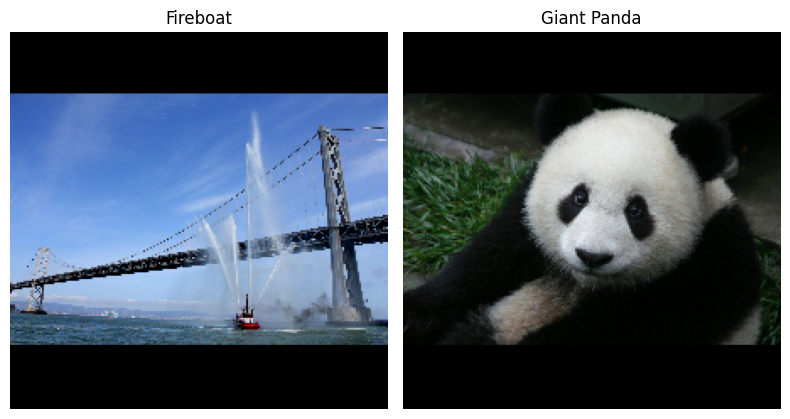

In [8]:
plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
  ax = plt.subplot(1, 2, n+1)
  ax.imshow(img_tensors)
  ax.set_title(name)
  ax.axis('off')
plt.tight_layout()

### 画像の分類

これらの画像を分類して、信頼性の高い上位 3 つの予測を表示します。以下は、上位 k の予測ラベルと確率を取得するユーティリティ関数です。

In [9]:
def top_k_predictions(img, k=3):
  image_batch = tf.expand_dims(img, 0)
  predictions = model(image_batch)
  probs = tf.nn.softmax(predictions, axis=-1)
  top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
  top_labels = imagenet_labels[tuple(top_idxs)]
  return top_labels, top_probs[0]

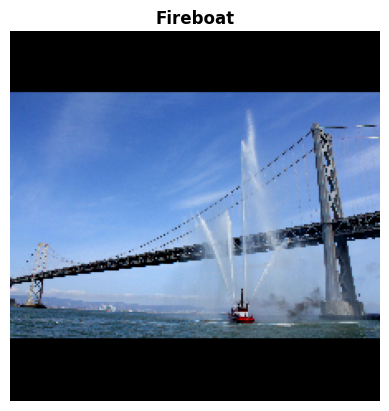

fireboat: 32.6%
pier: 12.7%
suspension bridge: 5.7%


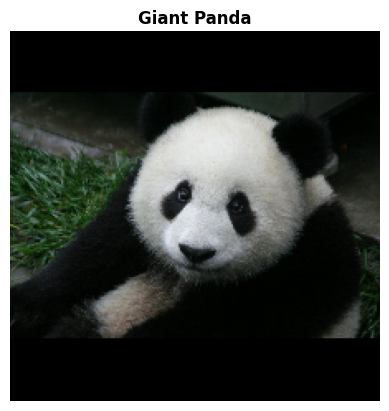

giant panda: 89.4%
teddy: 0.3%
gibbon: 0.3%


In [10]:
for (name, img_tensor) in img_name_tensors.items():
  plt.imshow(img_tensor)
  plt.title(name, fontweight='bold')
  plt.axis('off')
  plt.show()

  pred_label, pred_prob = top_k_predictions(img_tensor)
  for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.1%}')

## 統合勾配を計算する

Inception V1 は、ImageNet クラス確率値によって 0 と 1 の間に定義された入力特徴空間、画像ピクセル値、および出力空間のマッピングを説明する学習済みの関数です。ニューラルネットワークの初期の解釈可能性の手法では、モデルの予測関数に沿った特定のポイントで、どのピクセルがモデルの予測に対して最も急であるかを示す勾配を使用して特徴量重要度が割り当てられていました。ただし、勾配は、ピクセル値に関するモデルの予測関数の*局所的*な変更のみを説明しており、モデル予測関数全体を完全には説明していません。モデルが個々のピクセルの範囲と正しい ImageNet クラスとの関係を完全に「学習」するにつれ、このピクセルの勾配は*飽和*します。つまり、徐々に小さくなり、ゼロになることさえあります。 以下の単純なモデル関数を考察しましょう。

In [11]:
def f(x):
  """A simplified model function."""
  return tf.where(x < 0.8, x, 0.8)

def interpolated_path(x):
  """A straight line path."""
  return tf.zeros_like(x)

x = tf.linspace(start=0.0, stop=1.0, num=6)
y = f(x)

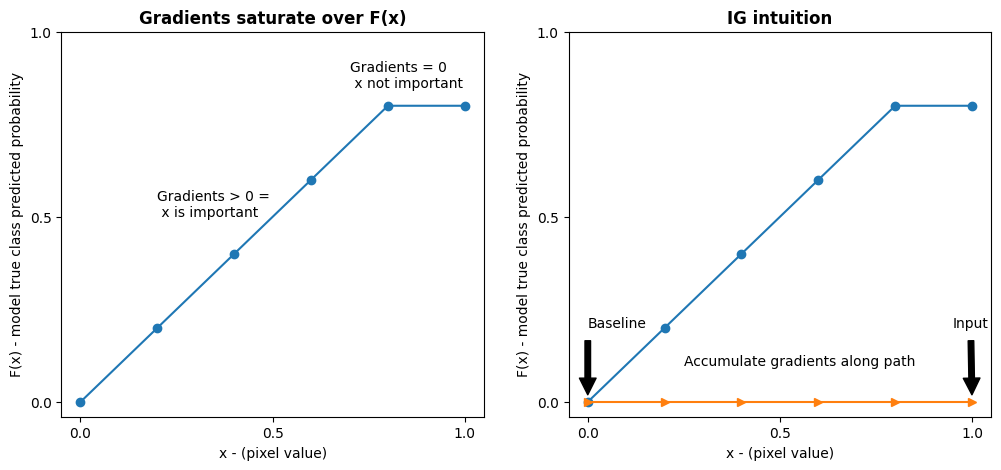

In [12]:
#@title
fig = plt.figure(figsize=(12, 5))
ax0 = fig.add_subplot(121)
ax0.plot(x, f(x), marker='o')
ax0.set_title('Gradients saturate over F(x)', fontweight='bold')
ax0.text(0.2, 0.5, 'Gradients > 0 = \n x is important')
ax0.text(0.7, 0.85, 'Gradients = 0 \n x not important')
ax0.set_yticks(tf.range(0, 1.5, 0.5))
ax0.set_xticks(tf.range(0, 1.5, 0.5))
ax0.set_ylabel('F(x) - model true class predicted probability')
ax0.set_xlabel('x - (pixel value)')

ax1 = fig.add_subplot(122)
ax1.plot(x, f(x), marker='o')
ax1.plot(x, interpolated_path(x), marker='>')
ax1.set_title('IG intuition', fontweight='bold')
ax1.text(0.25, 0.1, 'Accumulate gradients along path')
ax1.set_ylabel('F(x) - model true class predicted probability')
ax1.set_xlabel('x - (pixel value)')
ax1.set_yticks(tf.range(0, 1.5, 0.5))
ax1.set_xticks(tf.range(0, 1.5, 0.5))
ax1.annotate('Baseline', xy=(0.0, 0.0), xytext=(0.0, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
ax1.annotate('Input', xy=(1.0, 0.0), xytext=(0.95, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.show();

- **左**: ピクセル `x` のモデルの勾配は 0.0 から 0.8 の間で正ですが、0.8 から 1.0 の間で 0.0 になります。ピクセル `x` は、モデルを真のクラスの予測確率 80% に向かって押す上で明らかに大きな影響を与えています。*ピクセル <code>x</code> の重要度が小さいか不連続であることは理にかなっていますか？*

- **右**: IG の背後にある直観は、ピクセル `x` のローカル勾配を累積し、モデルの全体的な出力クラス確率にどれだけ追加または減算するかを表すスコアとしてその重要性を属性付けすることです。IG は 3 つの部分に分けて計算することができます。

    1. 0（基準点または開始点）と 1（入力ピクセルの値）の間の特徴空間の直線に沿って小さなステップを補間する
    2. 各ステップで、各ステップに関するモデルの予測間の勾配を計算する
    3. これらのローカル勾配を累積（累積平均）することで、基準と入力間の積分を近似する

この直感を強化するために、以下の例の「消防艇」画像に IG を適用して、上記の 3 つの部分を説明します。 

### 基準の確立

基準は、特徴量重要度を計算する際の開始点として使用される入力画像です。直感的に、基準の説明的な役割を、入力画像に存在する場合の「消防艇」に対する各ピクセルの影響と比較する「消防艇」予測に対する各ピクセルの不在の影響を表していると考えることができます。結果として、基準の選択は、ピクセル特徴量重要度を解釈し、視覚化する上での中心的役割を果たします。基準の選択に関するその他の説明については、このチュートリアルの最後にある「次のステップ」に記載されたリソースをご覧ください。ここでは、ピクセル値がすべてゼロである黒い画像を使用します。

ほかには、すべて白の画像、もしくはランダム画像といった選択肢を試すことができます。これは、`tf.random.uniform(shape=(224,224,3), minval=0.0, maxval=1.0)` で作成することができます。

In [13]:
baseline = tf.zeros(shape=(224,224,3))

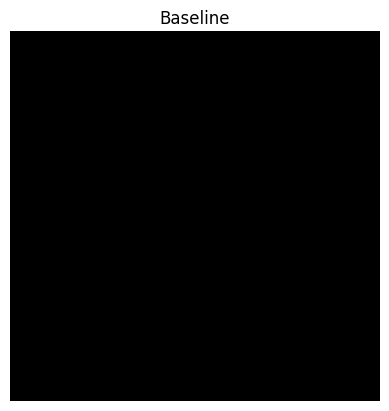

In [14]:
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

### 式からコードへのアンパック

次は、統合勾配の式です。

$IntegratedGradients_{i}(x) ::= (x_{i} - x'*{i})\times\int*{\alpha=0}^1\frac{\partial F(x'+\alpha \times (x - x'))}{\partial x_i}{d\alpha}$

それぞれ以下を意味します。

$_{i}$ = 特徴慮<br> $x$ = 入力<br> $x'$ = 基準<br> $\alpha$ = 特徴を摂動させる補間定数

実践的には、定積分を計算するのは、必ずしも数値的に可能とは限らず、計算コストがかかる可能性があるため、次の数値近似を計算します。

$IntegratedGrads^{approx}*{i}(x)::=(x*{i}-x'*{i})\times\sum*{k=1}^{m}\frac{\partial F(x' + \frac{k}{m}\times(x - x'))}{\partial x_{i}} \times \frac{1}{m}$

それぞれ以下を意味します。

$*{i}$ = 特徴量（個別のピクセル）<br> $x$ = 入力（画像テンソル）<br> $x'$ = 基準（画像テンソル）<br> $k$ = スケーリングされた特徴摂動定数<br> $m$ = 積分のリーマン和近似のステップ数<br> $(x*{i}-x'_{i})$ = 基準との差を表す項。これは、統合勾配をスケーリングし、元の画像に関してそれらを維持するために必要です。基準画像から入力までのパスはピクセル空間内にあります。IG を使用して直線に積分しているため（線形変換）、これは、十分なステップ数のある $\alpha$ に関し、補完された画像関数の微分の積分項におおよそ等しくなります。積分は、各ピクセルの勾配にパスに沿ったピクセルの変化を掛けたものを合計します。$x := (x' + \alpha(x-x'))$ に置き換えて、この積分を 1 つの画像から別の画像への均一なステップとして実装する方が簡単であるため、変数の変更によって、$dx = (x-x')d\alpha$ となります。$(x-x')$ 項は定数であり、積分から因数分解されます。

### 画像の補完

$IntegratedGrads^{approx}*{i}(x)::=(x*{i}-x'*{i})\times\sum*{k=1}^{m}\frac{\partial F(\overbrace{x' + \frac{k}{m}\times(x - x')}^\text{interpolate m images at k intervals})}{\partial x_{i}} \times \frac{1}{m}$

まず、基準と元の画像の間に[線形補間](https://en.wikipedia.org/wiki/Linear_interpolation)を生成します。補間画像は、元の式の $\alpha$ で表現される、基準と入力の間にある特徴空間の小さなステップとして考えることができます。

In [15]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

In [16]:
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

上記の関数を使用して、黒い基準画像と例の「消防艇」画像の間に、アルファ間隔で、線形パスに沿った補間画像を生成します。

In [17]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_name_tensors['Fireboat'],
    alphas=alphas)

補完画像を視覚化します。注意: $\alpha$ 定数は、各補完画像の強度が一貫して増加しているとも考えられます。

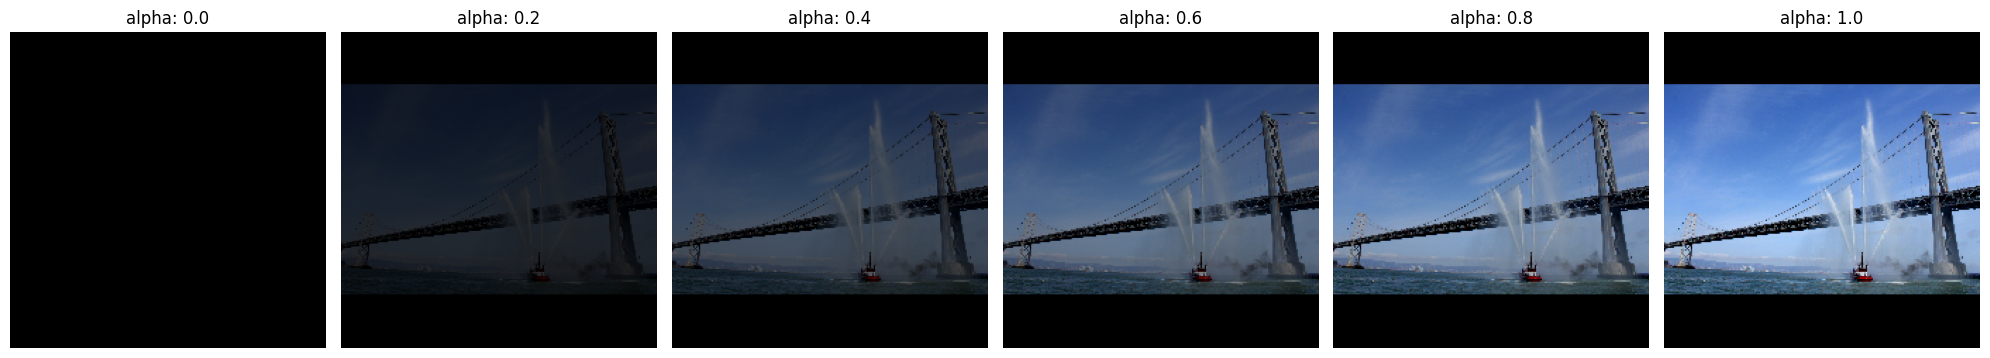

In [18]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();

### 勾配の計算

このセクションでは、特徴量の変化とモデルの予測の変化の関係を測定するために勾配を計算する方法を説明します。画像の場合、勾配は、どのピクセルがモデルが予測したクラスの確率に最も大きな効果があるかを示します。

$IntegratedGrads^{approx}*{i}(x)::=(x*{i}-x'*{i})\times\sum*{k=1}^{m}\frac{\overbrace{\partial F(\text{interpolated images})}^\text{compute gradients}}{\partial x_{i}} \times \frac{1}{m}$

次のような意味があります。<br> $F()$ = モデルの予測関数<br> $\frac{\partial{F}}{\partial{x_i}}$ = 各特徴量 $x_i$ に関するモデル F の予測関数の勾配（偏微分 $\partial$ のベクトル）

TensorFlow では、[`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) を使用して、簡単に勾配を計算できます。

In [19]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

正しい出力に関し、補間パスに沿った各画像の勾配を計算します。モデルが、各クラスの予測確率に変換するロジットを含む `(1, 1001)` 形状の `Tensor` を返すことを思い出してください。正しい ImageNet ターゲットクラスインデックスを画像の ` compute_gradients` 関数に渡す必要があります。

In [20]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=555)

`(n_interpolated_images, img_height, img_width, RGB)` 出力形状に注意してください。これは、補間パスに沿った画像の各ピクセルの勾配です。これらの勾配を、特徴空間内の小さなステップに対する、モデルの予測における変化を測定するものとして考えることができます。

In [21]:
print(path_gradients.shape)

(51, 224, 224, 3)


**勾配の飽和を視覚化する**

上記で計算した勾配は、モデルの「消防艇」の予測確率への*ローカル*変化を説明したものであり、*飽和*する可能性があることを思い出してください。

これらの概念は、次の 2 つの図に示すように、上記で計算した勾配を使用して視覚化されます。

In [22]:
pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 555]

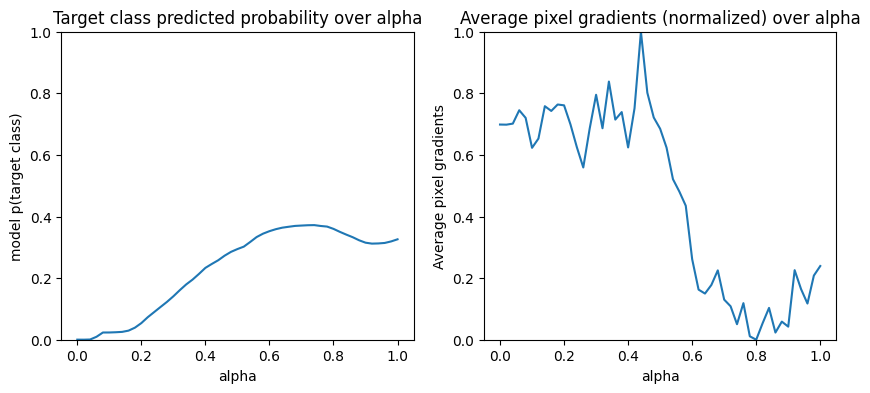

In [23]:
#@title
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

- **左**: この図は、モデルの「消防艇」クラスに対する信頼度がアルファでどのように変化するのかを示します。勾配または線の傾きが、最後の「消防艇」予測確率の約 40% に一定する前に、0.6 と 1.0 の間で大きく平たん化または飽和していることに注目してください。

- **右**: 右の図は、アルファの平均勾配の大きさをより直接的に示しています。値が 0 に急接近し、わずかながら 0 を下回っている様子に注目してください。実際、これらのピクセル勾配をゼロにすることで、モデルがピクセル（放水器）を学習したとしてユーザーが直感的に考える前に、モデルはアルファの低い値での勾配から一番「学習」して正しい予測を立てますが、アルファ値が元の入力画像に近づくにつれ、非常に不確実で、偽の船橋または放水のピクセルに焦点を当て続けます。

これらの重要な放水器のピクセルが「消防艇」予測に重要なものとして反映されるようにするには、これらの勾配を累積して、各ピクセルが「消防艇」の予測確率にどれほどの影響を与えるのかを正確に概算する方法について、さらにお読みください。


### 勾配の累積（積分近似）

IG の積分の数値近似を計算するにはさまざまな方法があり、関数の精度と収束のトレードオフもそれぞれに異なります。メソッドの一般的なクラスは、[リーマン和](https://en.wikipedia.org/wiki/Riemann_sum)と呼ばれます。ここでは、台形近似の法則を使用します（このチュートリアルの最後に、さまざまな近似方法を確認できるように、コードを追加しています）。

$IntegratedGrads^{approx}*{i}(x)::=(x*{i}-x'*{i})\times \overbrace{\sum*{k=1}^{m}}^\text{Sum m local gradients} \text{gradients(interpolated images)} \times \overbrace{\frac{1}{m}}^\text{Divide by m steps}$

この式から、`m` 勾配で加算して、`m` ステップで除算していることがわかります。この 2 つの演算を 3 番目の<em data-md-type="raw_html">入力画像間の `m` 個の補間予測のロカール勾配の平均</em>として実装することができます。

In [24]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

`integral_approximation` 関数は、基準と元の画像間の補間画像に関するターゲットクラスの確率の勾配を取ります。

In [25]:
ig = integral_approximation(
    gradients=path_gradients)

`m` 個の補間画像の勾配を平均化すると、元の「ジャイアントパンダ」画像と同じ形状の補間勾配テンソルが返されることを確認できます。

In [26]:
print(ig.shape)

(224, 224, 3)


### すべてを提供する

これまでの 3 つの部分を `IntegratedGradients` 関数に合わせて、[@tf.function](https://www.tensorflow.org/guide/function) デコレータを使用して、高性能のコーラブル TensorFlow グラフにコンパイルします。これは、以下のように、5 つの小さなステップとして実装されます。


$IntegratedGrads^{approx}*{i}(x)::=\overbrace{(x*{i}-x'*{i})}^\text{5.}\times \overbrace{\sum*{k=1}^{m}}^\text{4.} \frac{\partial \overbrace{F(\overbrace{x' + \overbrace{\frac{k}{m}}^\text{1.}\times(x - x'))}^\text{2.}}^\text{3.}}{\partial x_{i}} \times \overbrace{\frac{1}{m}}^\text{4.}$

1. アルファを生成します。$\alpha$

2. 補間画像を生成します。$(x' + \frac{k}{m}\times(x - x'))$

3. 入力特徴に関してモデル $F$ 出力予測間の勾配を計算します。$\frac{\partial F(\text{interpolated path inputs})}{\partial x_{i}}$

4. 勾配の平均化による積分近似 = $\sum_{k=1}^m \text{gradients} \times \frac{1}{m}$

5. 元の画像に関する統合勾配をスケーリングします。$(x_{i}-x'_{i}) \times \text{integrated gradients}$。このステップが必要なのは、複数の補間画像で累積された属性値が同じユニットにあり、元の画像のピクセル重要度を厳密に表すようにするためです。

In [27]:
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.    
  gradient_batches = []
    
  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
    gradient_batches.append(gradient_batch)
      
  # Concatenate path gradients together row-wise into single tensor.
  total_gradients = tf.concat(gradient_batches, axis=0)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [28]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

In [29]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=img_name_tensors['Fireboat'],
                                       target_class_idx=555,
                                       m_steps=240)

もう一度、IG 特徴量属性の形状が入力「消防艇」画像と同じであることを確認できます。

In [30]:
print(ig_attributions.shape)

(224, 224, 3)


論文では、サンプルに応じて、20 から 300 個のステップ数が推奨されています（積分を正確に近似するには、実際には、1,000 個以上となることがあります）。適切なステップ数を確認するためのその他のコードは、このチュートリアルの最後にある「次のステップ」のリソースをご覧ください。

### 特性の視覚化

属性を視覚化し、元の画像に重ねる準備が整いました。以下のコードでは、属性マスクを作成するために、カラーチャンネルの統合勾配の絶対値を加算しています。この描画方法では、モデルの予測に対する相対的な影響がキャプチャされます。 

In [31]:
#@title
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

「消防艇」画像の属性を見ると、モデルは放水器と放水を正しい予測に貢献するものとして識別しているのがわかります。

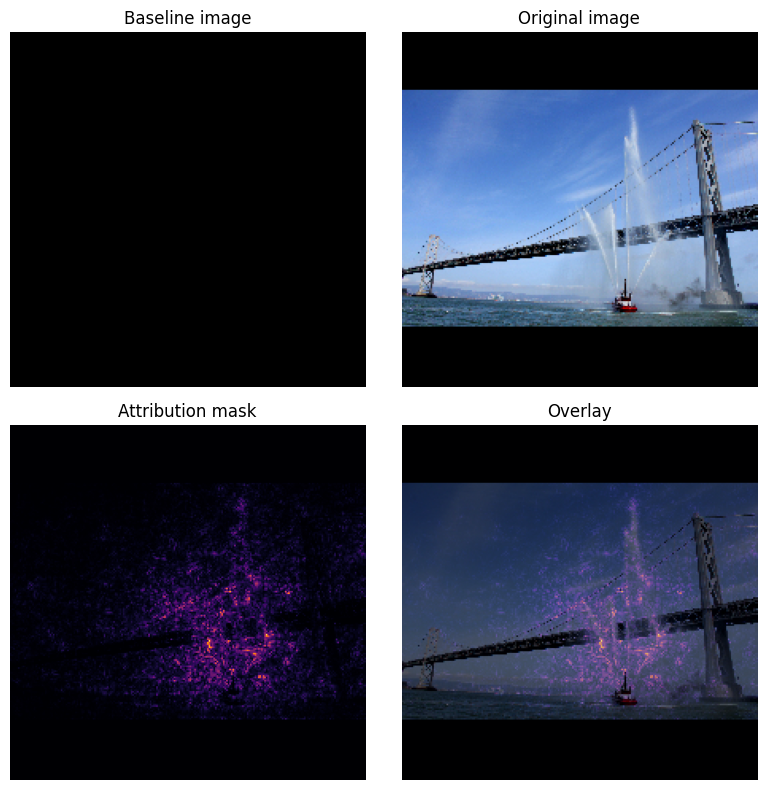

In [32]:
_ = plot_img_attributions(image=img_name_tensors['Fireboat'],
                          baseline=baseline,
                          target_class_idx=555,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

「ジャイアントパンダ」の画像では、属性はテクスチャ、鼻、およびパンダの顔の毛がハイライトされています。

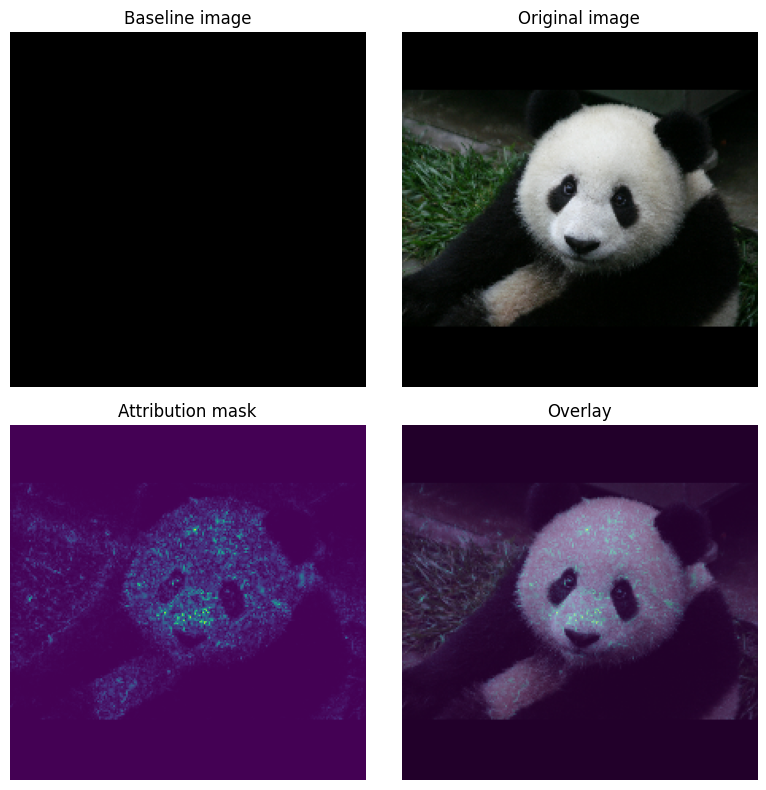

In [33]:
_ = plot_img_attributions(image=img_name_tensors['Giant Panda'],
                          baseline=baseline,
                          target_class_idx=389,
                          m_steps=55,
                          cmap=plt.cm.viridis,
                          overlay_alpha=0.5)

## 使用と制限

ユースケース

- モデルを展開する前に統合勾配のようなテクニックを使用すると、それがなぜ、どのように機能するのかに対する直感を得る上で役立ちます。このテクニックでハイライトされる特徴量は、直感と一致しているでしょうか。していない場合は、モデルやデータセットのバグか、過適合の可能性があります。

制限事項

- 統合勾配の手法では、個々のサンプルの特徴量重要度を得られますが、全データセットの全体的な特徴量重要度を知ることができません。

- 統合勾配の手法では、個々の特徴量重要度を得られますが、特徴量の相互作用や組み合わせを説明しません。

## Next steps

このチュートリアルでは、統合勾配の基本的な実装を説明しました。次のステップとして、このノートブックを参考にしながら、異なるモデルと画像を使ってこのテクニックを試してみることができます。

興味のある方には、[こちら](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/blogs/integrated_gradients)にさらに詳しいチュートリアル（異なる基準を使ったコード、積分近似の計算、十分なステップ数の決定が含まれます）が用意されています。 <br>.

理解を深めるには、論文「[Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365)」と、TensorFlow の前のバージョンでの実装が含まれた [Github リポジトリ](https://github.com/ankurtaly/Integrated-Gradients)をご覧ください。また、[distill.pub](https://distill.pub/2020/attribution-baselines/) では、特徴量属性、および異なる基準の影響を調べることができます。

実稼働の機械学習ワークフローに IG を統合して特徴量重大度、モデルの誤差分析、およびデータの歪み監視を行うことをお考えですか？IG 属性をサポートする Google Cloud の[説明可能な AI](https://cloud.google.com/explainable-ai)製品をご覧ください。Google AI PAIR リサーチグループでは、IG 特徴量属性の視覚化を含む、モデルのデバッグに使用できる [What-if ツール](https://pair-code.github.io/what-if-tool/index.html#about)もオープンソースとして提供しています。